# Bayesian Classifier
In this lab, you will implement and assess the performance of the Bayesian Classifier.

## Lab Instructions:
1. Read the explanation above each requirement very well
2. Read the requirement very well before jumping into the code.
3. Some requirements have essay questions in them, make sure you do NOT miss them.
4. PLEASE Read the hints! They are clear and made to help you complete the requirement as fast as you should 

In [111]:
#### always keep all your imports in the first cell ####
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import csv
import math

%matplotlib inline

## Requirement

In this requirement, you will build the Bayesian Classifier and test its performance. 

You are provided with a data file **data1.csv** containing list of points and their corresponding classes. The format of the data files is shown in the table below.

| |Class|Feature 1|Feature 1| 
|-|-|-|-|
|Point#1|1|0.271633|-2.93224|
|Point#2|1|7.020786|-1.98966|
|Point#3|1|2.901827|-0.91291|


You are also provided with a test data file **test_data.csv**. The file contains test points that are unlabelled (i.e. the class to which they belong is unknown).

In [112]:
# TODO [1] : Read the file 'data1.csv' into the variable data.
# data contains the training data together with labelled classes.
def read_data(file_name):
    # HINT 1: How is the data ordered in the file?
    # HINT 2: Do you need to cast the data you read from the file?
    data = np.asarray(pd.read_csv('data1.csv', sep=",", header=None))
    # print(data)
    return data


# read_data('data1.csv')


In [113]:
def read_test_data():

    # TODO [2.A]: Read the file 'test_data.csv' into the variable test_data
    # test_data contains the unlabelled test class.
    # HINT: Do you need to cast the data you read from the file?

    test_data = np.asarray(pd.read_csv('test_data.csv', sep=",", header=None))

    # TODO [2.B]: Read the file 'test_data_true.csv' into the variable test_data_true
    # test_data_true contains the actual classes of the test instances, which you will compare
    # against your predicted classes.
    # HINT: Do you need to cast the data you read from the file?

    test_data_true = np.asarray(pd.read_csv(
        'test_data_true.csv', sep=",", header=None))
    return test_data, test_data_true

# read_test_data()


### Machine Learning Terminlology
Machine learning problems use common termonology (names and notiations) to refer to certain things. It is useful to use this termonology throughout your code to make it readable.

| | |
|:-|:--- |
|$M$:|A scalar; represents the number of training points in the training set.|
|$K$:|A scalar; represents the number of test points in the test set.|
|$N$:|A scalar; represents the number of features of training set/test set (dimensionality of data).|
|$X$:|A numpy array of shape $(M \times N)$ containing the training data **without** its labels, where $M$ is the number of training points and $N$ is the number of features in the dataset (or dimensionality of features). <br/> Each element in $X$ is a tuple $(X_1, X_2, \dots, X_N)$ where $N$ is the number of features in the dataset.| 
|$X_{test}$:| A numpy array of shape $(K \times N)$ containing the test data, where $K$ is the number of test points and $N$ is the number of features in the dataset (or dimensionality of features). <br/> Each element in $X_{test}$ is a tuple $(X_1, X_2, \dots, X_N)$ where $N$ is the number of features in the dataset. <br/> The number of columns in $X_{test}$ is equal to the number of columns in $X$ (because they have the same number of features). However, the number of rows in $X_{test}$ is different to the number of rows in $X$.|
|**$Y$:| A numpy array of shape $(M \times 1)$ containing the labels of the training data. Each row in $Y$ corresponds to the label of the training point in $X$.<br/> For example, $Y[j]$ corresponds to the label of the training point $X[j]$ where $0<=j<M$.|



In [114]:
# TODO [3]: Fill the values of M, K, N, X, XTest, and Y respectively.
# Do not fill them manually (i.e. do not set N = 3). They should be generic for any input file.
training_data = read_data('data1.csv')
test_data, test_data_true = read_test_data()

numClasses = 3
M = training_data.shape[0]
N = training_data.shape[1] - 1
K = test_data.shape[0]

X = training_data[:, 1:]
X_Test = test_data
Y = training_data[:, 0]


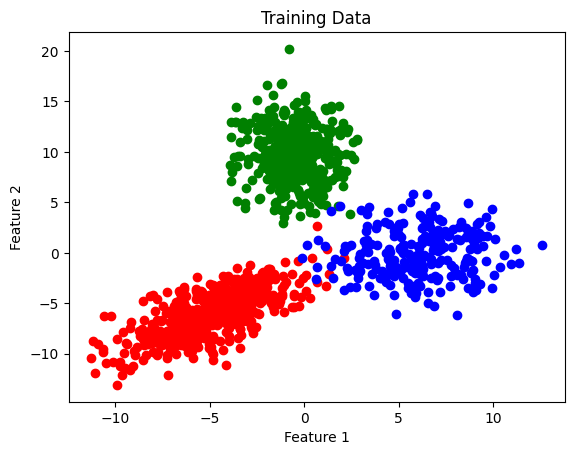

In [115]:
# TODO [4]: Draw a scatter plot for traning data, where each class is coloured by the colour corresponding
#           to its index in the colors array.
# Class 1 should be coloured in red, Class 2 should be coloured in green, and Class 3 should be coloured in blue.
# Hint: We have done a similar plot in the previous lab. What operation do we need to select training data
#       belonging to a certain class?

colors = ['r', 'g', 'b', 'c', 'y']

# This is X given that its the first class (X|C1)
X_C1 = training_data[Y == 1][:, 1:]
# This is X given that its the second class (X|C2)
X_C2 = training_data[Y == 2][:, 1:]
# This is X given that its the third class (X|C3)
X_C3 = training_data[Y == 3][:, 1:]


plt.scatter(X_C1[:, 0], X_C1[:, 1], color=colors[0])
plt.scatter(X_C2[:, 0], X_C2[:, 1], color=colors[1])
plt.scatter(X_C3[:, 0], X_C3[:, 1], color=colors[2])

plt.title('Training Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [116]:
## What do you notice about the plot? (Write everything you can think of)
'''
    Your Answer:

    - The dataset consists of three main clusters each corresponding to data belong to one class.

    - The overlap between the green cluster and the other two clusters is minimal compared to the overlap between the blue and red clusters.

    - We can easily calculate the decision boundary between any two classes

    - The red cluster exhibits the highest variance among the three, followed by the blue. The feature causing most of the variance in them is Feature 1.

    - The blue cluster doesn't seem to be as dense as the other two clusters.

''' 

"\n    Your Answer:\n\n    - The dataset consists of three main clusters each corresponding to data belong to one class.\n\n    - The overlap between the green cluster and the other two clusters is minimal compared to the overlap between the blue and red clusters.\n\n    - We can easily calculate the decision boundary between any two classes\n\n    - The red cluster exhibits the highest variance among the three, followed by the blue. The feature causing most of the variance in them is Feature 1.\n\n    - The blue cluster doesn't seem to be as dense as the other two clusters.\n\n"

### Bayesian Classifier
The Bayesian Classifier calculates the probability of the test point belonging to each class, then the class with highest probability is assigned to the test point.

Classification of $x_{test}$ = $argmax_{i} P\big(C_i|x_{test}\big)$ = $argmax_{i} P(x|C_i) * P(C_i)$

* $P(C_i|x_{test})$: Posterior probability
* $P(x|C_i)$: Class-conditional probability (or distribution)
* $P(C_i)$: Class apriori probability
                
**Note that** $P(C_i|x_{test}) \neq P(x_{test}|C_i) * P(C_i)$. Instead,  $P(C_i|x_{test}) = \frac{P(x_{test}|C_i) * P(C_i)}{P(x_{test})}$. However, when we compare multiple classes, the denominator $P(x_{test})$ is independent of the class $i$ and can be regarded as normalizing factor.

**We start by** computing statistical parameters about each class from the data. 

For each class, we are interested in **three** parameters that will be used for calculating the Gaussian class-conditional distribution and the posterior probability.

These parameters are:

|||
|:-|:-|
|**Class Apriori Probability: ($P_C$)**| A scalar; the probability of class occurence (how frequent this class appears in the training data)|
|**Class Mean: ($\mu$)**| A vector of shape $(N \times 1)$, it is the expected value (mean) calculated from the training points of each class.|
|**Class Covariance Matrix: ($\Sigma$)**| A square symmetric matrix of shape $(N \times N)$ representing the covariances between all the feature calculated from the training points of the class. <br/> For example: Matrix element $\sigma^2_{12}$ is the covariance between the 1st and the 2nd features|



In [117]:
# A list of size (numClasses, 1) containing the a priori probabilities of each class in the training set.
pClasses = []

# A numpy array of size (numClasses, N) containing the mean points of each class in the training set.
estimate_means = []
# HINT: USE NP.MEAN

# A numpy array of size (numClasses, N, N) containing the covariance matrices of each class in the training set.
estimate_covariances = []
# HINT: USE NP.COV (Pay attenention for what it takes as an argument)
X_Classes = [X_C1, X_C2, X_C3]
for classIndex in range(numClasses):
    # TODO [5]: Estimate the parameters of the Gaussian distributions of the given classes.
    # Fill pClasses, estimate_means, and estimate_covariances in this part
    # Your code should be vectorized WITHOUT USING A SINGLE FOR LOOP.

    pClasses.append(round(np.sum(Y == (classIndex + 1))/len(Y),6))
    X_Class = X_Classes[classIndex]
    # For each class we need the mean w.r.t each of the two features
    estimate_means.append([np.mean(X_Class[:, 0]), np.mean(X_Class[:, 1])])
    estimate_covariances.append(np.cov(X_Class.T))

estimate_means = np.array(estimate_means)
estimate_covariances = np.array(estimate_covariances)


In [118]:
### Test your implementation ###
### DO NOT CHANGE THIS CODE ###
assert len(pClasses) == numClasses,\
        'Incorrect class apriori probability list, it should be of length {}'.format(len(pClasses))
assert np.sum(pClasses)==1,\
        'Sum of apriori probabilities should be 1, found {}'.format(np.sum(pClasses))

assert estimate_means.shape == (numClasses, N),\
        'Incorrect estimated means, it should be of shape {}'.format((numClasses, N))
assert estimate_covariances.shape == (numClasses, N, N),\
        'Incorrect estimate covariance matrices, it should be of shape {}'.format((numClasses, N, N))

**The second step** in the classifier is to calculate the class-conditional density using the Gaussian destribution:

$P(x|C_i) = \mathcal{N}(x; \mu_i, \Sigma_i) = \frac{1}{(2\pi)^{\frac{N}{2}}|\Sigma_i|^{\frac{1}{2}}} exp\big(\frac{-1}{2}(x-\mu_i)^T\Sigma^{-1}_{i}(x-\mu_i)\big)$

In [119]:
# TODO 6: Implement the multivariate normal gaussian distribution with parameters mu and sigma, and return the
#  value in prob.
def multivariate_normal_gaussian(X, mu, sigma):
    scale = (2 * np.pi)**(len(mu)/2) * np.linalg.det(sigma)**(0.5)
    prob = np.exp(-0.5 * ( (X - mu).T @ np.linalg.inv(sigma) @  (X - mu))) / scale
    return prob

In [120]:
### Test your implementation ###
### DO NOT CHANGE THIS CODE ###
np.random.seed(90)
assertion_x = np.random.rand(3).reshape(-1,1)
assertion_mu = np.random.rand(3).reshape(-1,1)
assertion_sigma = np.random.rand(9).reshape(3,3)
assertion_probability = multivariate_normal_gaussian(assertion_x, assertion_mu, assertion_sigma)[0][0]
assertion_probability = round(assertion_probability, 1)

assert assertion_probability == 7.8,\
    'Incorrect Gaussian Probability calculated'

In [121]:
def Bayes(X, C, pClasses, estimate_means, estimate_covariances, N):    # computes P(X|C)*P(C)
    classConditional = multivariate_normal_gaussian(
        X, estimate_means[C], estimate_covariances[C])
    proir = pClasses[C]
    posterior_est = classConditional * proir
    return posterior_est


**The final step** is to go for each test point, calculate its posterior probability against each class, then classify it to the class with the highest posterior probability.

In [122]:
# TODO [7]: Apply the Bayesian Classifier to predict the classes of the test points.
# predicted_classes: A numpy array of size (K, 1) where K is the number of points in the test set. Every element in this array
predicted_classes = []
# contains the predicted class of Bayes classifier for this test point.

for i in range(X_Test.shape[0]):
    print("For test point:", X_Test[i])
    classProbabilities = np.zeros(numClasses)
    # TODO [7.A]: Compute the probability that the test point X_Test[i] belongs to each class in numClasses.
    #  Fill the array classProbabilities accordingly.
    classProbabilities[0] = Bayes(
        X_Test[i], 0, pClasses, estimate_means, estimate_covariances, N)
    classProbabilities[1] = Bayes(
        X_Test[i], 1, pClasses, estimate_means, estimate_covariances, N)
    classProbabilities[2] = Bayes(
        X_Test[i], 2, pClasses, estimate_means, estimate_covariances, N)

    # TODO [7.B]: Find the prediction of the test point X_Test[i] and append it to the predicted_classes array.
    predicted_classes.append(np.argmax(classProbabilities) + 1)

    # the first class is the left most in the scatter plot
    print('Class Probabilities: ', classProbabilities)
    print("Predicted class is :", predicted_classes[i])
    print("******************************************************************************")


For test point: [10.70141426  3.87253627]
Class Probabilities:  [2.65667617e-12 2.14599760e-17 2.49128185e-04]
Predicted class is : 3
******************************************************************************
For test point: [-3.81831787 -5.00977814]
Class Probabilities:  [1.54057746e-02 1.59733797e-10 1.94606724e-07]
Predicted class is : 1
******************************************************************************
For test point: [-3.57071936  9.96036181]
Class Probabilities:  [7.93462973e-20 1.36556743e-03 5.38716919e-11]
Predicted class is : 2
******************************************************************************
For test point: [ 4.94309043 -0.01539406]
Class Probabilities:  [1.95768925e-06 1.94246360e-08 5.69469636e-03]
Predicted class is : 3
******************************************************************************
For test point: [ 4.26082551 -0.61349358]
Class Probabilities:  [6.2406293e-06 4.9842336e-08 4.7278965e-03]
Predicted class is : 3
*****************

In [123]:
# TODO [8]: Compute the accuracy of the generated Bayesian classifier 
# WITHOUT USING ANY FOR LOOPs.
accuracy = np.sum(np.array(predicted_classes) == np.array(test_data_true).reshape(-1))/len(test_data_true)
print('Accuracy = ' + str(round(accuracy,4) * 100) + '%')

Accuracy = 95.56%


C:\Users\Zeyad Tarek\AppData\Local\Temp\ipykernel_21412\2093901419.py:24: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


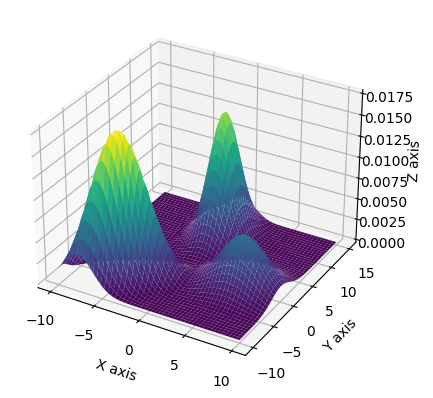

In [124]:
# TODO [9]: Generate a 3D-plot for the generated distributions. x-axis and y-axis represent the features of the data,
#           where z-axis represent the Gaussian probability N at this point.

x = np.linspace(-10, 10, 300)
y = np.linspace(-10, 15, 300)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z1 = np.zeros(X.shape)
Z2 = np.zeros(X.shape)
Z3 = np.zeros(X.shape)

for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        # TODO [9]: Fill in the matrix Z which will represent the probability distribution of every point.
        # Z[i,j] represents the joint probability N(x,y) for x = i and y = j.
        # We want to draw the gaussian probability N(x,y) for all points.
        Z1[i, j] =  multivariate_normal_gaussian([X[i, j], Y[i, j]], estimate_means[0], estimate_covariances[0]) * pClasses[0]
        Z2[i, j] =  multivariate_normal_gaussian([X[i, j], Y[i, j]], estimate_means[1], estimate_covariances[1]) * pClasses[1]
        Z3[i, j] =  multivariate_normal_gaussian([X[i, j], Y[i, j]], estimate_means[2], estimate_covariances[2]) * pClasses[2]
        Z[i, j] = max(Z1[i,j], Z2[i,j], Z3[i,j])

# Make a 3D plot, do not change code
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()


In [125]:
# How can you judge your plot is correct?
'''
    Your Answer:
    By comparing to the dataset's scatterplot (at the specific class we're plotting for). 
    The Gaussian should be centered at the mean of the points and the way it's skewed/scaled depends on the covariance.
    If the data was spread in a certain direction, the covariance parameter will make the Gaussian skew/scale so that
    it spreads in a similar way.
'''

"\n    Your Answer:\n    By comparing to the dataset's scatterplot (at the specific class we're plotting for). \n    The Gaussian should be centered at the mean of the points and the way it's skewed/scaled depends on the covariance.\n    If the data was spread in a certain direction, the covariance parameter will make the Gaussian skew/scale so that\n    it spreads in a similar way.\n"